## Transfer Learning EfficientB7using Keras

In [19]:
import tensorflow as tf
print(len(tf.config.experimental.list_physical_devices('GPU')))

1


In [20]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\bhuwa\miniconda3_1\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [1]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
# from keras.applications.vgg16 import VGG16
import tensorflow.keras.applications 
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Dataset new/Train'
valid_path = 'Dataset new/Test'


In [3]:
import tensorflow as tf
resnet152V2 = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in resnet152V2.layers:
    layer.trainable = False

In [ ]:
  # useful for getting number of output classes
folders = glob('Dataset new/Train/*')

In [ ]:
Aiphids_folder = glob('Dataset new/Test/Aiphids/*')
Army_worms_folder = glob('Dataset new/Test/Army worm/*')
Bacterial_Blight_folder = glob('Dataset new/Test/Bacterial Blight/*')
Healthyfolder = glob('Dataset new/Test/Healthy/*')
Powdery_Mildew_folder = glob('Dataset new/Test/Powdery Mildew/*')
Target_spot_folder = glob('Dataset new/Test/Target spot/*')

In [ ]:
img_arr = [Aiphids_folder, Army_worms_folder, Bacterial_Blight_folder, Healthyfolder, Powdery_Mildew_folder, Target_spot_folder] 

In [ ]:
actual = []  
for i in range(6):
    curr = [i]*len(img_arr[i])
    actual.extend(curr)
print(actual)

In [12]:
# our layers - you can add more if you want
x = Flatten()(resnet152V2.output)

In [13]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet152V2.input, outputs=prediction)

In [14]:

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

block6c_add (Add)               (None, 7, 7, 384)    0           block6c_drop[0][0]               
                                                                 block6b_add[0][0]                
__________________________________________________________________________________________________
block6d_expand_conv (Conv2D)    (None, 7, 7, 2304)   884736      block6c_add[0][0]                
__________________________________________________________________________________________________
block6d_expand_bn (BatchNormali (None, 7, 7, 2304)   9216        block6d_expand_conv[0][0]        
__________________________________________________________________________________________________
block6d_expand_activation (Acti (None, 7, 7, 2304)   0           block6d_expand_bn[0][0]          
__________________________________________________________________________________________________
block6d_dwconv (DepthwiseConv2D (None, 7, 7, 2304)   57600       block6d_expand_activation[0][0]  
__________

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [16]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Dataset new/Train',
                                                 target_size = (224, 224),
                                                 batch_size =32 ,
                                                 class_mode = 'categorical')

Found 17898 images belonging to 6 classes.


In [18]:
test_set = test_datagen.flow_from_directory('Dataset new/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5819 images belonging to 6 classes.


In [19]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20


ResourceExhaustedError:  OOM when allocating tensor with shape[32,192,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block2a_expand_conv/Conv2D (defined at <ipython-input-18-2d02736eff38>:8) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_42281]

Function call stack:
train_function


In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_EfficientB7_GPU.h5')

In [78]:
import matplotlib.pyplot as plt

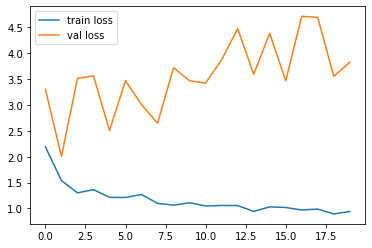

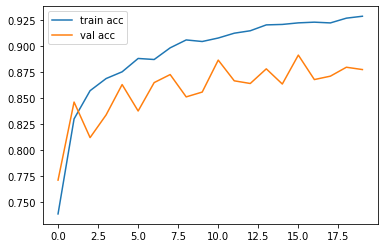

<Figure size 432x288 with 0 Axes>

In [79]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [80]:

y_pred = model.predict(test_set)


In [81]:
y_pred

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [9.9996424e-01, 3.5732126e-05, 4.6365393e-08, 3.2816427e-10,
        1.3673096e-09, 1.8717980e-09],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [82]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [83]:
y_pred

array([0, 1, 0, ..., 0, 0, 3], dtype=int64)

In [84]:
 def model_predict(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocessing the image
    x = image.img_to_array(img)
    x = x / 255  # Scaling
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    preds = np.argmax(preds, axis=1)
    return preds


In [85]:
test_values = []
for i in img_arr:
    for j in i:
        test_values.append(model_predict(j,model))

In [86]:
print(test_values)

[array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([5], dtype=int64), array([2], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([4], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([4], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64),

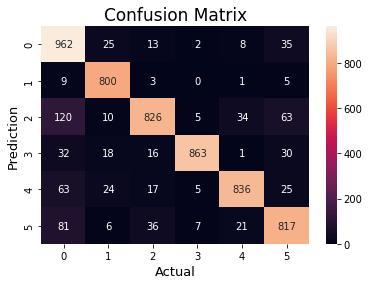

In [87]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 

true_labels = test_set.classes


#cm = confusion_matrix(true_labels, y_pred)
cm = confusion_matrix(actual,test_values)
sns.heatmap(cm, 
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [88]:
accuracy_score(actual,test_values, normalize=True)

0.8771266540642723

In [89]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [90]:
model=load_model('model_resnet152V2_GPU.h5')

In [91]:
img_data

NameError: name 'img_data' is not defined

In [28]:
img=image.load_img('Dataset/val/diseased cotton leaf/dis_leaf (7)_iaip.jpg',target_size=(224,224))



In [29]:
x=image.img_to_array(img)
x

array([[[ 91.,  92.,  84.],
        [ 97.,  98.,  90.],
        [ 96.,  97.,  89.],
        ...,
        [156., 146., 134.],
        [162., 152., 140.],
        [168., 158., 146.]],

       [[ 82.,  83.,  75.],
        [ 91.,  92.,  84.],
        [ 92.,  93.,  85.],
        ...,
        [156., 146., 134.],
        [171., 161., 149.],
        [177., 167., 155.]],

       [[ 70.,  71.,  63.],
        [ 81.,  82.,  74.],
        [ 85.,  86.,  78.],
        ...,
        [165., 155., 143.],
        [170., 160., 148.],
        [186., 176., 164.]],

       ...,

       [[174., 185., 129.],
        [182., 190., 143.],
        [163., 164., 132.],
        ...,
        [107., 143.,  82.],
        [107., 138.,  78.],
        [103., 134.,  74.]],

       [[175., 197., 132.],
        [174., 191., 136.],
        [167., 175., 136.],
        ...,
        [108., 143.,  87.],
        [107., 142.,  84.],
        [ 99., 134.,  76.]],

       [[170., 192., 127.],
        [166., 183., 128.],
        [157., 1

In [30]:
x.shape

(224, 224, 3)

In [31]:
x=x/255

In [32]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [33]:
model.predict(img_data)

array([[3.0653393e-01, 2.6646352e-09, 5.7741558e-09, 6.9346607e-01]],
      dtype=float32)

In [34]:
a=np.argmax(model.predict(img_data), axis=1)

In [35]:
a==1

array([False])